In [1]:
# Loading packages 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import datetime as dt # for date and time manipulation

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # data visualization
init_notebook_mode(connected=True)

import cufflinks as cf #  to call plots directly off of a pandas dataframe
cf.go_offline()

# 1. Exploratory Data Analysis and Visualization

In [2]:
# Loading dataset train, test and store
train=pd.read_csv('C:\\Users\\prashant\\Desktop\\DATA SCIENCE\\Rossman Store\\train.csv')
test=pd.read_csv('C:\\Users\\prashant\\Desktop\\DATA SCIENCE\\Rossman Store\\test.csv')
store=pd.read_csv('C:\\Users\\prashant\\Desktop\\DATA SCIENCE\\Rossman Store\\store.csv')

C:\Users\prashant\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
# Looking into each dataset size
print('training dataset shape',train.shape)
print('testing dataset shape',test.shape)
print('store dataset shape',store.shape)

training dataset shape (1017209, 9)
testing dataset shape (41088, 8)
store dataset shape (1115, 10)


In [4]:
# train dataset
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [5]:
# test dataset
test.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [6]:
# store dataset
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [7]:
# Samples having 0 sales 
print('Sample having 0 sales :',train[train['Sales']<=0].shape,'\n')
print('Store Open : 1,','Store Closed : 0')
print(train['Open'].value_counts(),'\n')
print('Sample having closed store and sale is 0 :',train[(train['Sales']<=0)&(train['Open']==0)].shape)

Sample having 0 sales : (172871, 9) 

Store Open : 1, Store Closed : 0
1    844392
0    172817
Name: Open, dtype: int64 

Sample having closed store and sale is 0 : (172817, 9)


* The train dataset have total 172817 samples having 0 sale and the store is closed. Model is building to predict the sale, therefore getting rid of irrelevant samples 

In [8]:
# making new train dataset having sales greater than zero
train=train[train['Sales']>0]
print('New training dataset shape',train.shape)

New training dataset shape (844338, 9)


In [9]:
# basic information about columns of train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844338 non-null  int64 
 1   DayOfWeek      844338 non-null  int64 
 2   Date           844338 non-null  object
 3   Sales          844338 non-null  int64 
 4   Customers      844338 non-null  int64 
 5   Open           844338 non-null  int64 
 6   Promo          844338 non-null  int64 
 7   StateHoliday   844338 non-null  object
 8   SchoolHoliday  844338 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.4+ MB


* Date column having date information but is of object type, so have to convert into datetime format 
* Dataset does not cantain any missing values

In [10]:
# Converting into datetime format 
train['Date']=pd.to_datetime(train['Date'])
train.sort_values(by='Date',ascending=True,inplace=True)
train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)

# Start date record in dataset
start_date=train['Date'][0]
print('Start date :',start_date)

# End date record in dataset
end_date=train['Date'][844337]
print('End date :',end_date)

Start date : 2013-01-01 00:00:00
End date : 2015-07-31 00:00:00


In [11]:
# unique values of categorical columns 
for i in ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']:
    print( i+':',train[i].unique())

DayOfWeek: [2 3 4 5 6 7 1]
Open: [1]
Promo: [0 1]
StateHoliday: ['a' '0' 'b' 'c' 0]
SchoolHoliday: [1 0]


* Open column having only 1 value so no need of this column
* StateHoliday column having two identical values but in different format so need to deal with this 

In [12]:
# Droping 'Open' column and making correction in 'StateHoliday' column
index=train[train['StateHoliday']==0].index
train['StateHoliday'][index]='0'
train['StateHoliday'].value_counts()
train.drop('Open',axis=1,inplace=True)

# Note : I have converted numeric into string format in StateHoliday column because majority of variables are in string format

In [13]:
# Checking for negative values
pd.options.display.float_format = '{:.0f}'.format # in order to round up the numbers 
train.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844338,844338,844338,844338,844338,844338
mean,558,4,6956,763,0,0
std,322,2,3104,401,0,0
min,1,1,46,8,0,0
25%,280,2,4859,519,0,0
50%,558,3,6369,676,0,0
75%,837,5,8360,893,1,0
max,1115,7,41551,7388,1,1


* We don't have negative values in dataset, therefore dataset is very clean

### 1.1 Visualization based on Days of Week

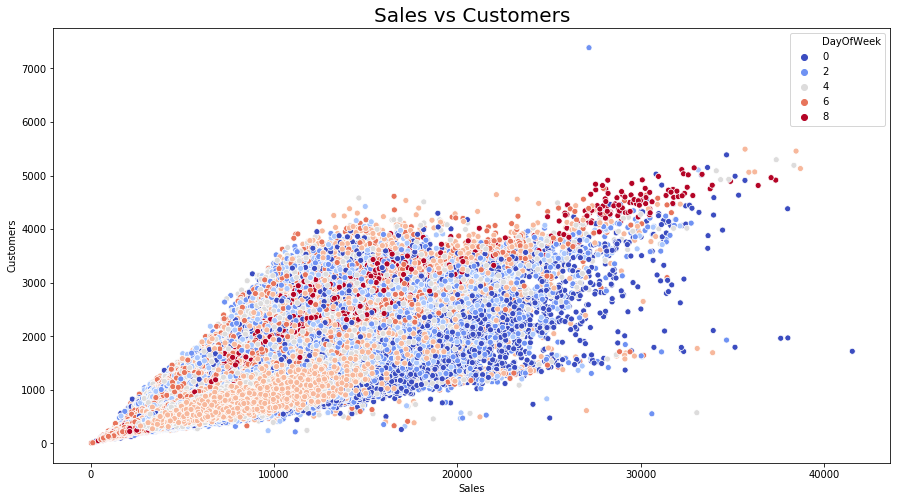

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: DayOfWeek, dtype: int64


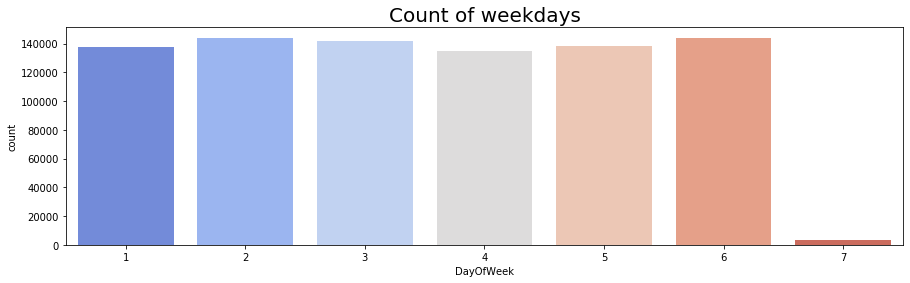

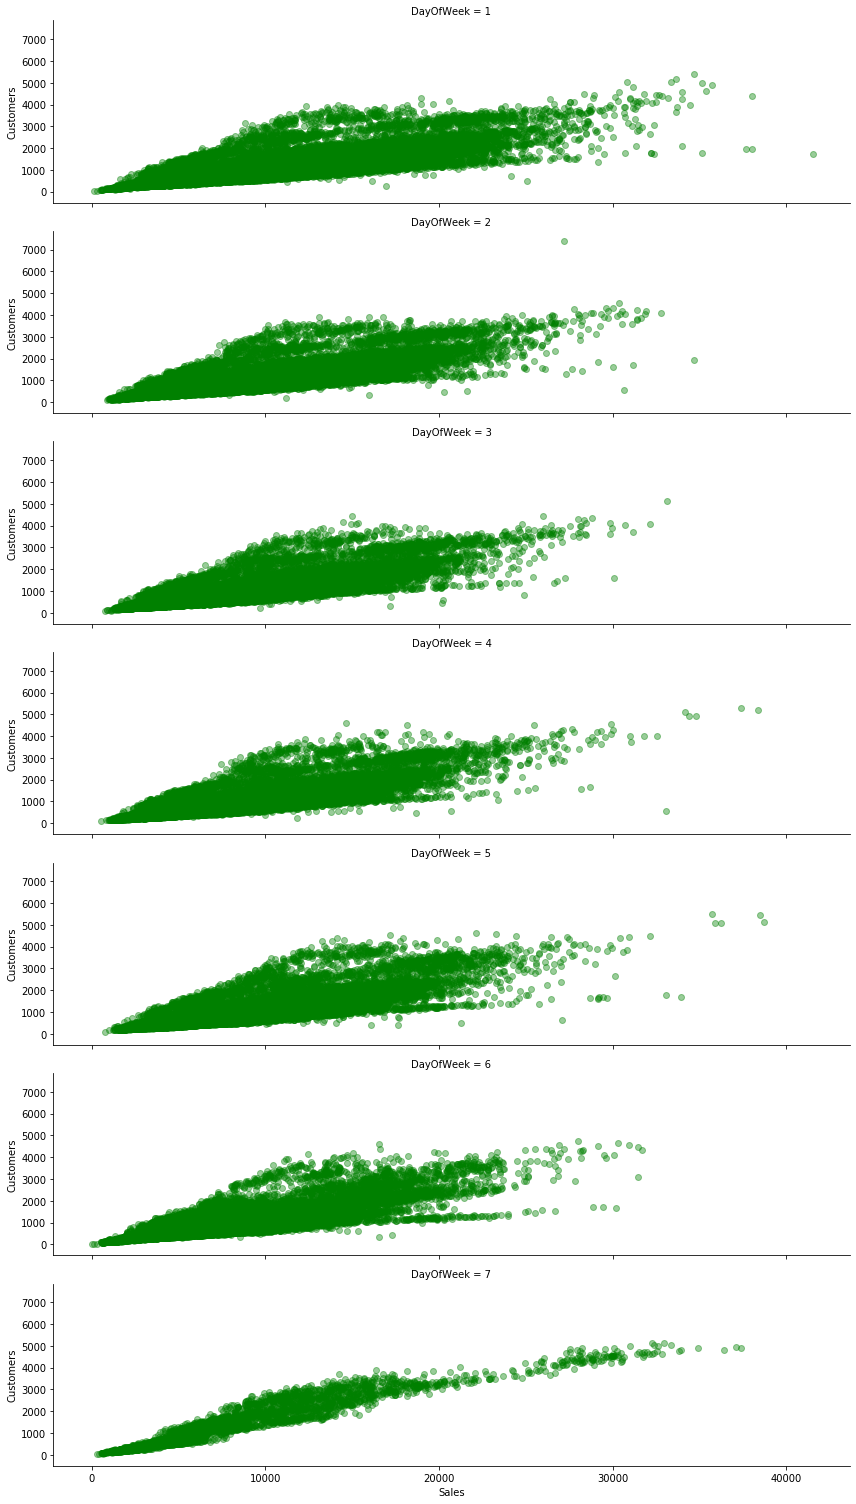

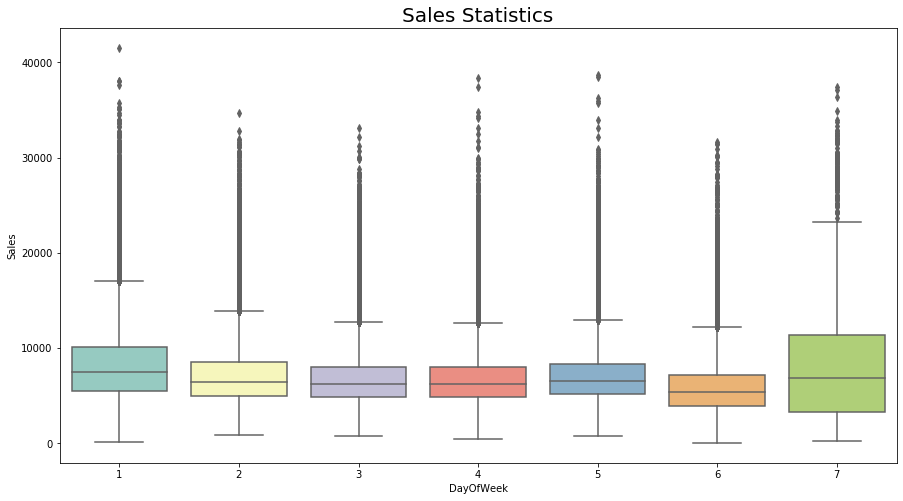

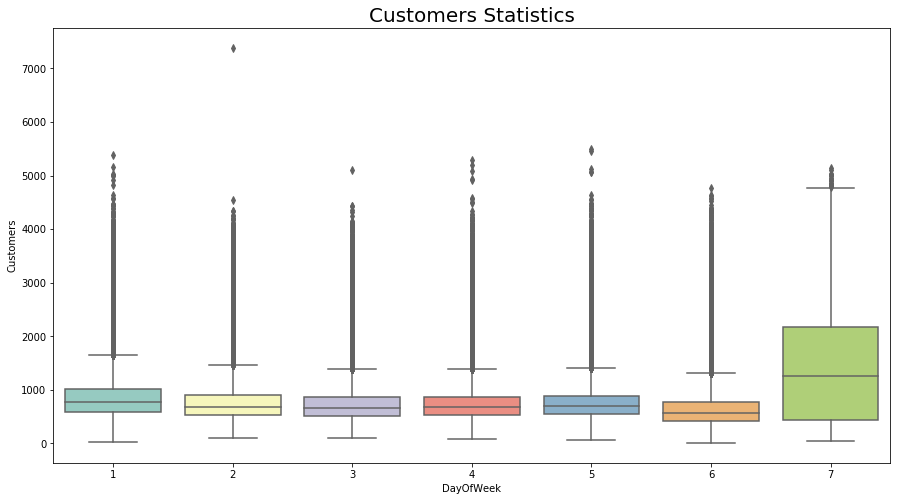

In [14]:
 # Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='DayOfWeek',palette='coolwarm')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

# Count of Weekdays 
plt.figure(figsize=(15,4))
print(train['DayOfWeek'].value_counts())
sns.countplot('DayOfWeek',data=train,palette='coolwarm')
plt.title('Count of weekdays',fontdict={'fontsize':20})
plt.show()

# Weekdays wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='DayOfWeek',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='green',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(15,8))
sns.boxplot(y='Sales',x='DayOfWeek',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()


# Boxplot - "Customers"
plt.figure(figsize=(15,8))
sns.boxplot(y='Customers',x='DayOfWeek',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* The 7th day of week has very less variability as compare to other days of week
* The count of 7th days is very less as compare to other days but the average sales and average number of customers are pretty much high. One possible reason could be on sunday customers comes for a specific commodity as an essential need for survival

### 1.2 Visualization based on running Promo

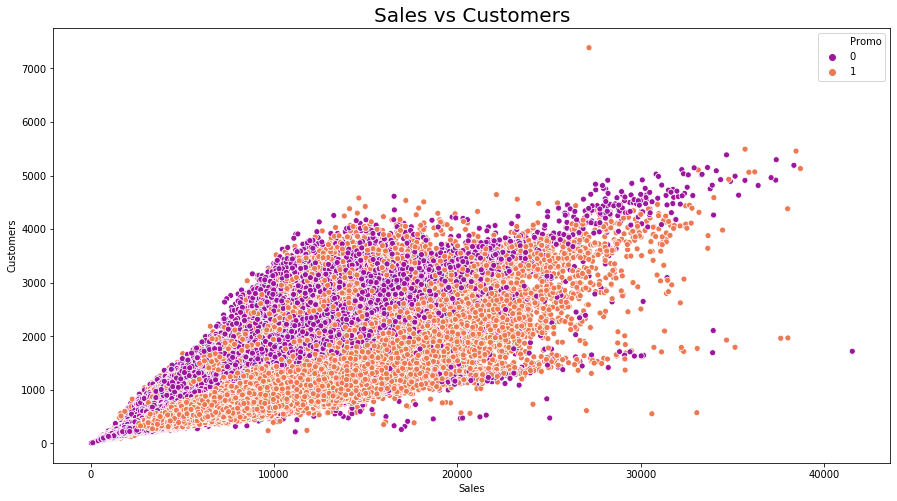

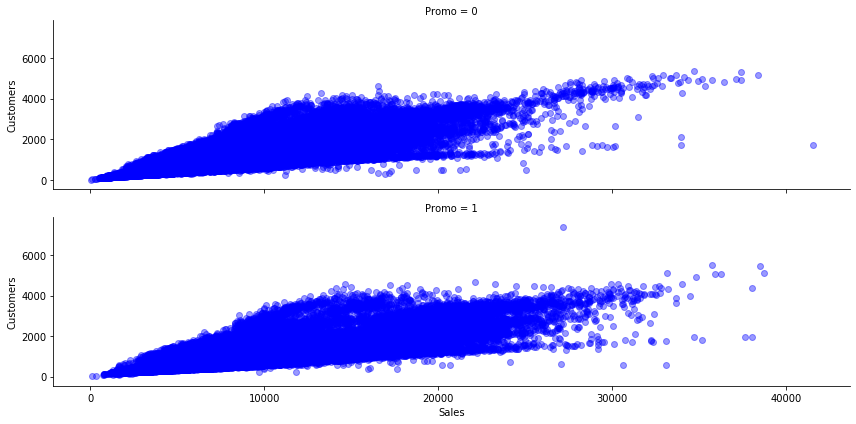

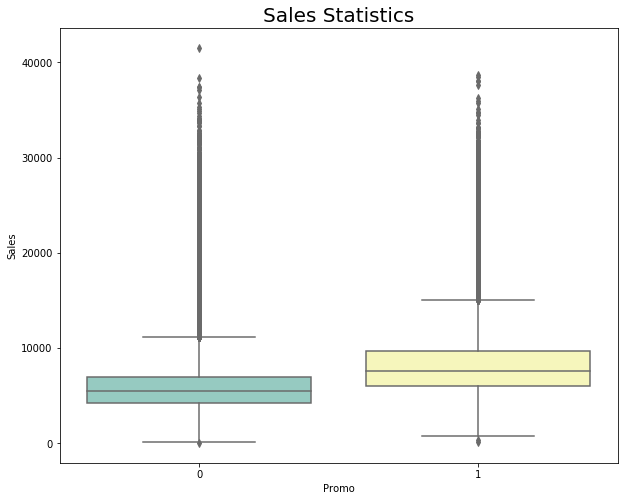

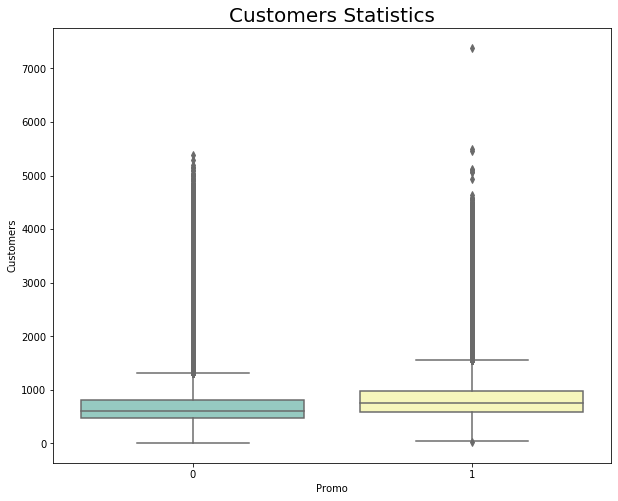

In [15]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='Promo',palette='plasma')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

# Promo wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='Promo',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='blue',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='Promo',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='Promo',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* There is much difference in sale before and after running Promo. It indicates that promo have done a great job in increasing the sale
* Not much noticable difference is seen in number of customers visit to store. Promo idea was not capable to attract new customers but the buying quantity of existing old customers have increased, therefore overall the running of promo worked  

### 1.3 Visualization based on State Holidays 

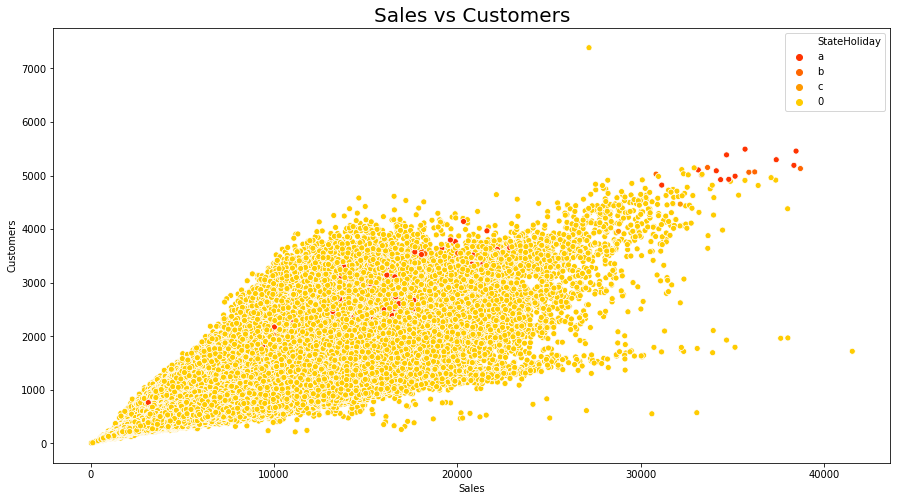

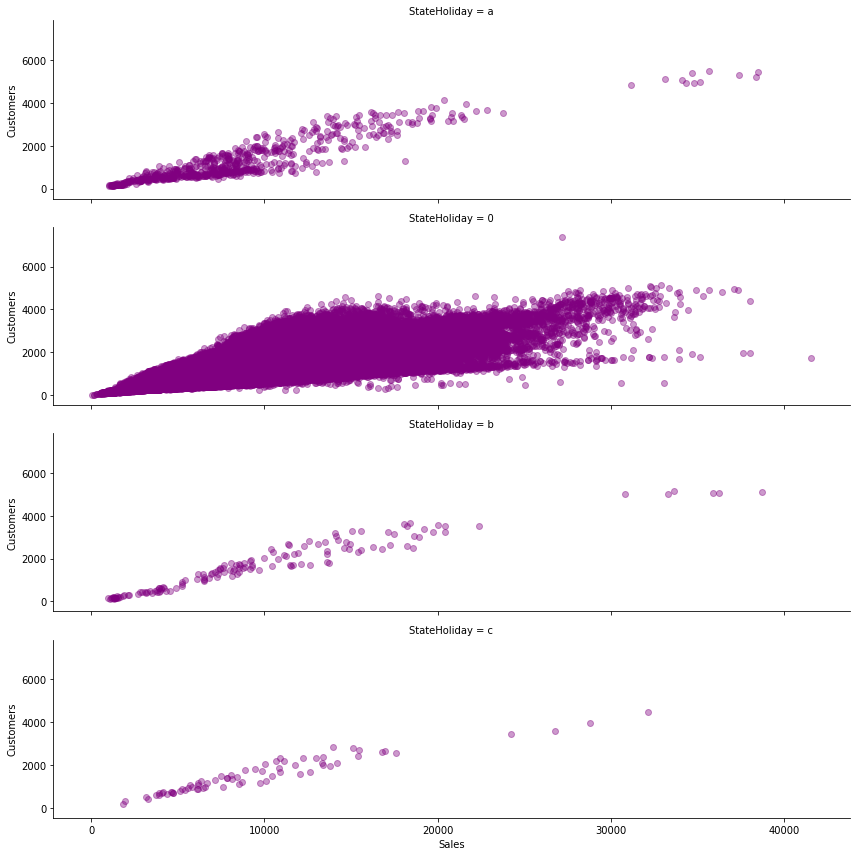

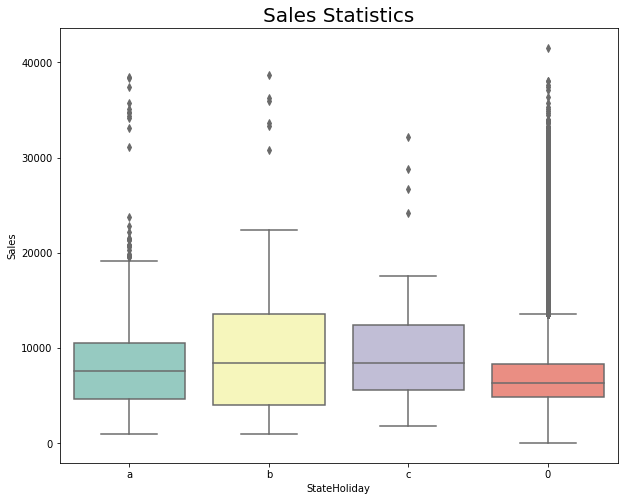

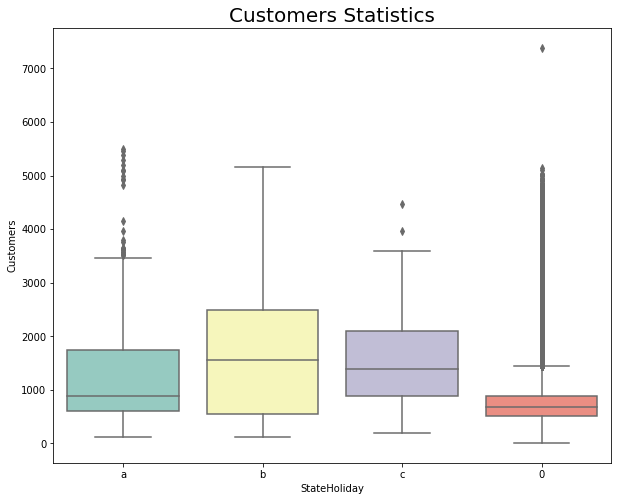

In [16]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='StateHoliday',palette='autumn',hue_order=['a','b','c','0'])
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

# State Holiday wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='StateHoliday',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='purple',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='StateHoliday',data=train,order=['a','b','c','0'],palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* People are more often to buy more on Christmas and Easter festival, therefore sales and count of customers visit are more on this seasons
* But it is clearly seen the variation in public choice is less in these festival as people tend to buy particular range and type of product,where as the opposite behavior is been observed when there is no holiday

### 1.4 Visualization based on School Holidays 

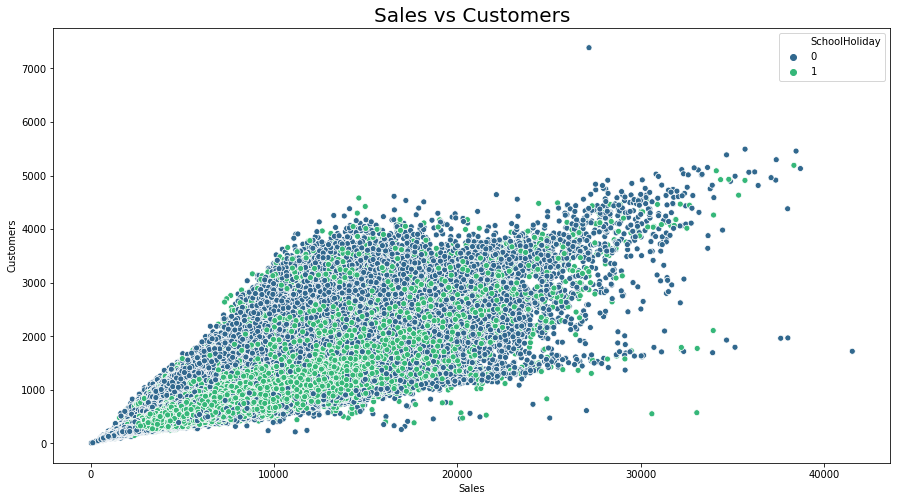

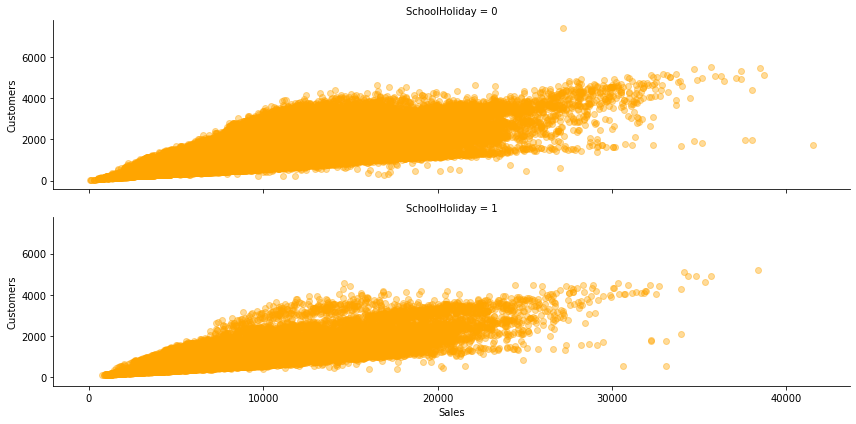

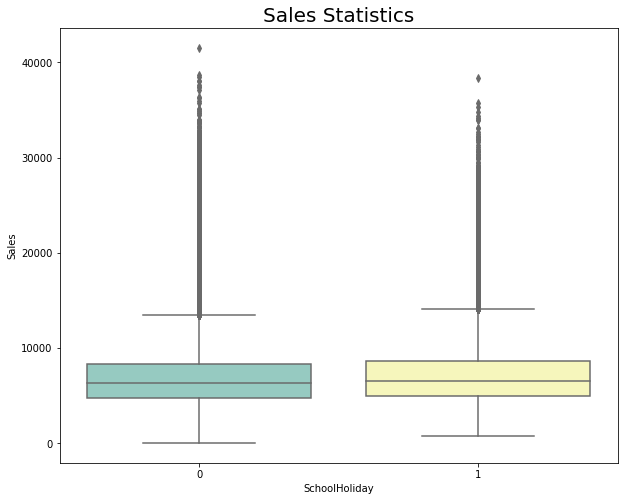

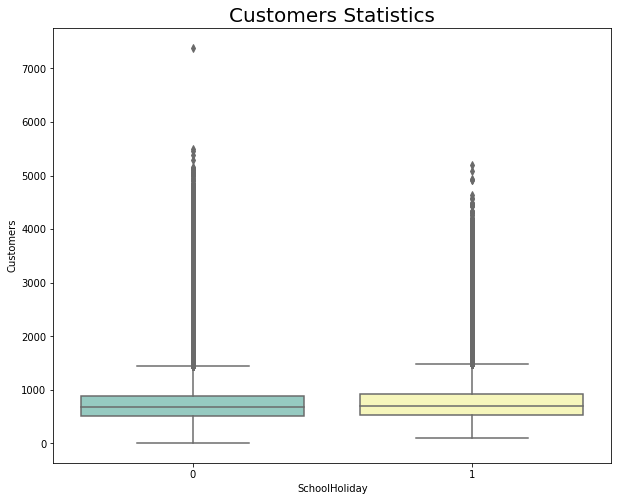

In [17]:
# Scatter plot "Sales Vs Customers"
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales',y='Customers',data=train,hue='SchoolHoliday',palette='viridis')
plt.title('Sales vs Customers',fontdict={'fontsize':20})
plt.show()

# State Holiday wise scatter plot between Sales and Customers
g=sns.FacetGrid(row='SchoolHoliday',data=train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='orange',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='SchoolHoliday',data=train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* Not much difference is observed by the closure of public schools

# 2. Feature Engineering

In [18]:
# Making new column of sales per customers 
train['SalesPerCustomer']=train['Sales']/train['Customers']
train['SalesPerCustomer']

0         4
1         7
2         5
3         6
4         4
         ..
844333   11
844334   14
844335   13
844336   10
844337    9
Name: SalesPerCustomer, Length: 844338, dtype: float64

## 2.1 Table_1 : Average sales, average number of customers and average sales per customers based on weekdays and whether the promo is running on that day. 

In [19]:
Table_1=pd.pivot_table(data=train,index=['DayOfWeek','Promo'],values=['Sales','Customers','SalesPerCustomer'],aggfunc='mean').round(0)
Table_1.rename(columns=lambda x : 'Avg_' + x, inplace=True)

# Visualization
Table_1.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sales and Average Customers',xTitle='(DayOfWeek,Promo)')
Table_1.iplot(y='Avg_SalesPerCustomer',title='Average Sales per Customers',xTitle='(DayOfWeek,Promo)')

Table_1

Avg_Customers  Avg_Sales  Avg_SalesPerCustomer
DayOfWeek Promo                                                
1         0                743       6223                     9
          1                943       9773                    11
2         0                688       5716                     9
          1                841       8278                    10
3         0                673       5618                     9
          1                799       7686                    10
4         0                689       5751                     9
          1                810       7599                    10
5         0                735       6344                     9
          1                825       7744                    10
6         0                660       5875                     9
7         0               1442       8225                     6

* No promo was runned on weekends.
* The average sales and average number of customers on weekdays while running promo is high than not running promo.
* The average sale on sunday is quite high than some of the weekdays and the average number of customers is the highest on sunday.
* The average sale per customer is also high on days when promo was runned but the weekends is showing low sales rate. This means people are not buying even though they are capable of as it is evident in the weekdays.
* Should capture the profit potential seen on weekends by running Promos on weekends 

## 2.2 Table_2 : Average sales, average number of customers and average sales per customer based on State Holidays and whether the promo is running on that day. 

In [20]:
Table_2=pd.pivot_table(data=train,index=['Promo','StateHoliday'],values=['Sales','Customers','SalesPerCustomer'],aggfunc='mean').round(0)
Table_2.rename(columns=lambda x : 'Avg_' + x, inplace=True)

# Visualization
Table_2.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sales and Average Customers',xTitle='(Promo,StateHoliday)')
Table_2.iplot(y='Avg_SalesPerCustomer',title='Average Sales per Customers',xTitle='(Promo,StateHoliday)')

Table_2

Avg_Customers  Avg_Sales  Avg_SalesPerCustomer
Promo StateHoliday                                                
0     0                       696       5927                     9
      a                      1411       8127                     6
      b                      1380       7947                     7
      c                      1569       9744                     6
1     0                       844       8227                    10
      a                      1174       8775                     8
      b                      2270      13575                     6

* As early said Christman and Easter festival season shows high rate of sales 

In [21]:
# Checking the columns of store dataset
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


* There are lots of column having null values
* Some columns are not having right format data, so need to take care of it

In [22]:
# Converting Promo2 column data from integer to category type
store['Promo2']=store['Promo2'].astype(object)
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                        object
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [23]:
# Checking the unique values of category columns
for i in store.columns[store.dtypes=='object']:
    print(i,':',store[i].unique(),'\n')

StoreType : ['c' 'a' 'd' 'b'] 

Assortment : ['a' 'c' 'b'] 

Promo2 : [0 1] 

PromoInterval : [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec'] 



* Dataset is pretty much clear

## 2.3 Creating Dataframe - "avg_store" and merging with store dataset for further analysis

In [24]:
pd.options.display.float_format='{:.3f}'.format # in order to show number upto 3 decimal place

# avg_store Dataframe containing columns : 'Average Sales','Average Customers','Average Sales Per Customer'
avg_store=train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x : 'Avg_' + x,inplace=True)
avg_store.reset_index(inplace=True)

# Adding column Max_Customers(containing maximum value of customers) to avg_store Dataframe 
Max_customer=train.groupby('Store')['Customers'].max()
avg_store=pd.merge(avg_store,Max_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Max_Customers'},inplace=True)

# Adding column Min_Customers(containing mimimum value of customers) to avg_store Dataframe 
Min_customer=train.groupby('Store')['Customers'].min()
avg_store=pd.merge(avg_store,Min_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Min_Customers'},inplace=True)

# Adding column Std_Customers(containing Standard Deviation value of customers) to avg_store Dataframe 
Std_customer=train.groupby('Store')['Customers'].std()
avg_store=pd.merge(avg_store,Std_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Std_Customers'},inplace=True)

# Adding column Med_Customers(containing Median value of customers) to avg_store Dataframe 
Med_customer=train.groupby('Store')['Customers'].median()
avg_store=pd.merge(avg_store,Med_customer,how='inner',on='Store')
avg_store.rename(columns={'Customers':'Med_Customers'},inplace=True)

avg_store.head()

# In order to capture all the variability of customer columns, these much columns are made 

,Store,Avg_Sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers
0,1,4759.096,564.050,8.393,1130,298,93.707,550.000
1,2,4953.901,583.999,8.408,1164,230,155.374,575.500
2,3,6942.569,750.077,9.118,1579,381,170.280,744.000
3,4,9638.402,1321.753,7.250,2216,856,198.348,1301.500
4,5,4676.275,537.340,8.611,1081,180,165.605,564.000


In [25]:
# Merging avg_store with store
store=pd.merge(store,avg_store,how='inner',on='Store')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Avg_Sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers
0,1,c,a,1270.000,9.000,2008.000,0,nan,nan,NaN,4759.096,564.050,8.393,1130,298,93.707,550.000
1,2,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct",4953.901,583.999,8.408,1164,230,155.374,575.500
2,3,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct",6942.569,750.077,9.118,1579,381,170.280,744.000
3,4,c,c,620.000,9.000,2009.000,0,nan,nan,NaN,9638.402,1321.753,7.250,2216,856,198.348,1301.500
4,5,a,a,29910.000,4.000,2015.000,0,nan,nan,NaN,4676.275,537.340,8.611,1081,180,165.605,564.000


In [26]:
# Removing missing values in CompetitionDistance column
index=store[store['CompetitionDistance'].isnull()].index
store.loc[index,'CompetitionDistance']=0
store['CompetitionDistance'].isnull().any() # for checking

False

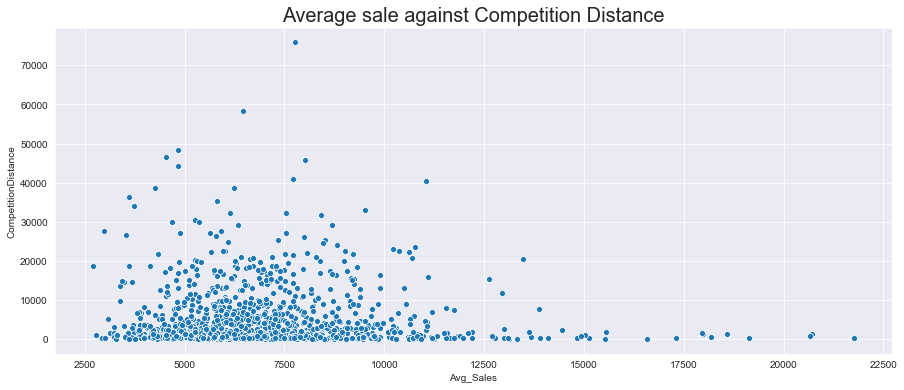

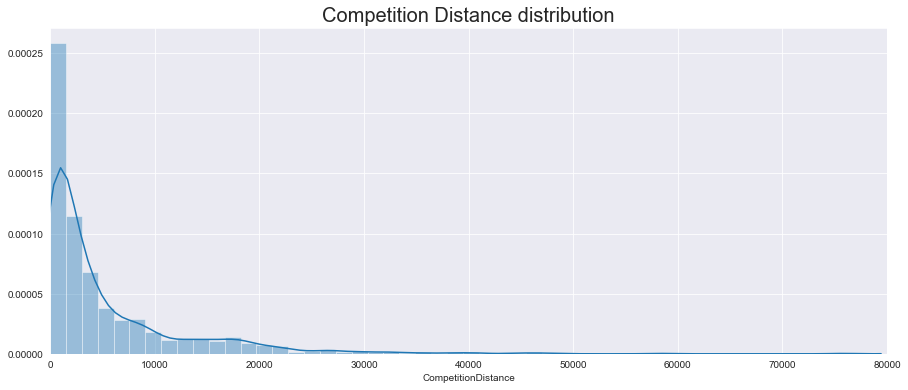

In [27]:
# Scatter plot - Average sale against Competition Distance
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')
sns.scatterplot(x='Avg_Sales',y='CompetitionDistance',data=store)
plt.title('Average sale against Competition Distance',fontdict={'fontsize':20})
plt.show()

# Visualization of Competition Distance data
plt.figure(figsize=(15,6))
sns.distplot(store['CompetitionDistance'])
plt.title('Competition Distance distribution',fontdict={'fontsize':20})
plt.xlim(0,80000)
plt.show()

* It seens there are less competitor's store near to Rossman's store
* Even though many competitor's are near to Rossman's store, the sale is far good enough to beat the compoetition. May be this is because good service quality, better behaviour towards customers and last but not least is the quality of product.

In [28]:
# unique value check 

print('CompetitionOpenSinceMonth :',store['CompetitionOpenSinceMonth'].unique(),'\n')

print('CompetitionOpenSinceYear :',store['CompetitionOpenSinceYear'].unique(),'\n')

print('Promo2SinceWeek :',store['Promo2SinceWeek'].unique(),'\n')

print('Promo2SinceYear :',store['Promo2SinceYear'].unique())

CompetitionOpenSinceMonth : [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.] 

CompetitionOpenSinceYear : [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.] 

Promo2SinceWeek : [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.] 

Promo2SinceYear : [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


In [29]:
# Getting free from missing values

index=store[(store['CompetitionOpenSinceMonth'].isnull())&(store['CompetitionOpenSinceYear'].isnull())].index
store.loc[index,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]=0

index=store[(store['Promo2SinceWeek'].isnull())&(store['Promo2SinceYear'].isnull())&(store['Promo2']==0)].index
store.loc[index,['Promo2SinceWeek','Promo2SinceYear']]=0

store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']].isnull().any() # To check

CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2SinceWeek              False
Promo2SinceYear              False
dtype: bool

In [30]:
# Converting from float into integer type
store[['CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear',
       'Promo2SinceWeek',
       'Promo2SinceYear']]=store[['CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear',
                                  'Promo2SinceWeek',
                                  'Promo2SinceYear']].astype(int)

store[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']].dtypes # To check

CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2SinceWeek              int32
Promo2SinceYear              int32
dtype: object

In [31]:
# Setting Promo Interval equal to zero for those who are not continuing Promo and for missing values
index=store[(store['Promo2']==0)&(store['PromoInterval'].isnull().any())].index
store.loc[index,'PromoInterval']=0

store['PromoInterval'].isnull().any() # To check

False

In [32]:
# Last check in columns of store
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int32  
 5   CompetitionOpenSinceYear   1115 non-null   int32  
 6   Promo2                     1115 non-null   object 
 7   Promo2SinceWeek            1115 non-null   int32  
 8   Promo2SinceYear            1115 non-null   int32  
 9   PromoInterval              1115 non-null   object 
 10  Avg_Sales                  1115 non-null   float64
 11  Avg_Customers              1115 non-null   float64
 12  Avg_SalesPerCustomer       1115 non-null   float64
 13  Max_Customers              1115 non-null   int64

* The data is clean and free from missing values

## 2.4 Visualization based on Store type

<Figure size 1080x576 with 0 Axes>

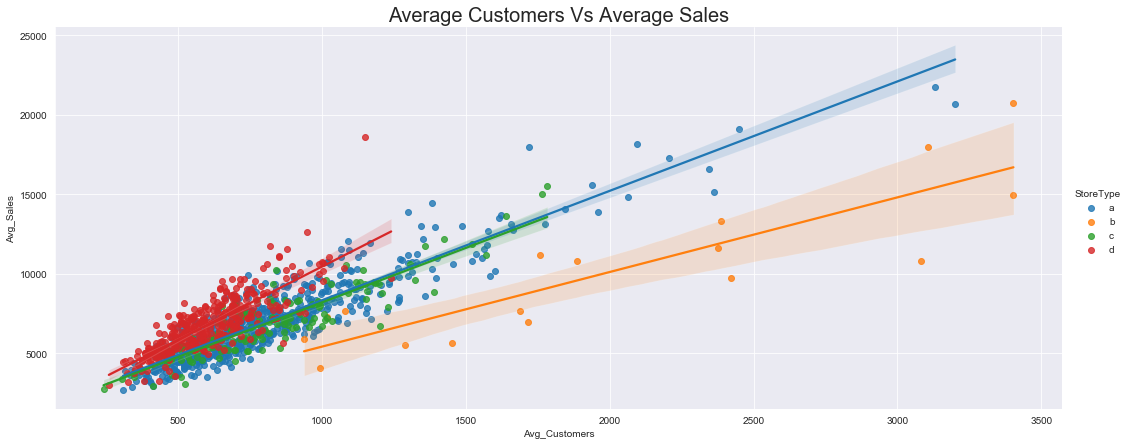

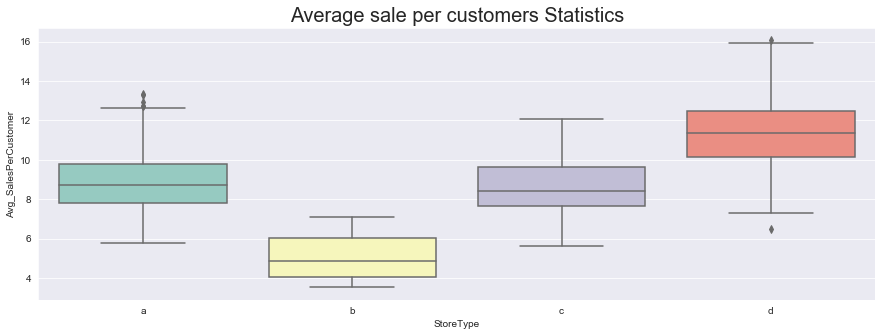

In [33]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='StoreType',data=store,hue_order=['a','b','c','d'],height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers 
plt.figure(figsize=(15,5))
sns.boxplot(x='StoreType',y='Avg_SalesPerCustomer',data=store,order=['a','b','c','d'],palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* Store type d is having much higher sale but the variability is very less as people are buying one particular set of products 
* Store type a and c are same sales but both are less than d type
* The least one is b type store and its shows large variability. May be this type of store is located in rural or suburban area 
* As expected the sales rate of d type is higher than a and c type and b type have very less sales rate 

## 2.5 Visualization based on Assortment

<Figure size 1080x576 with 0 Axes>

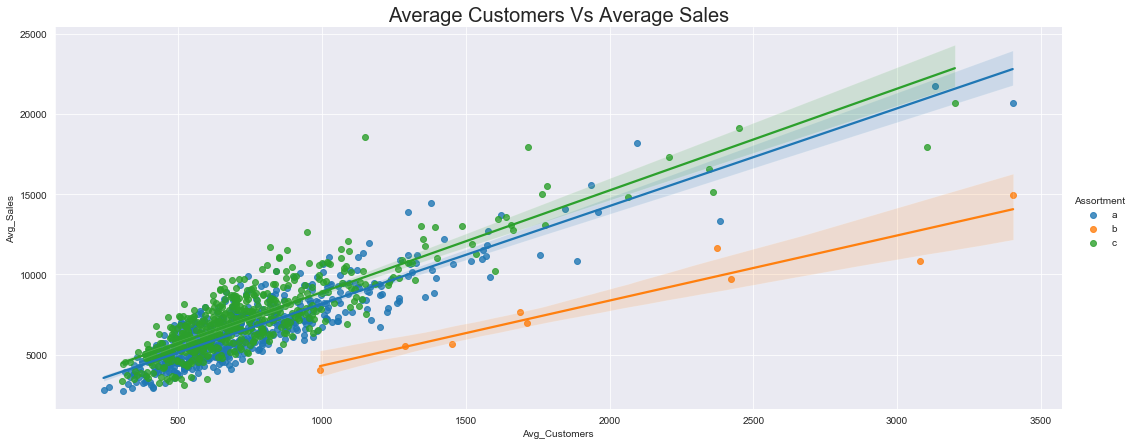

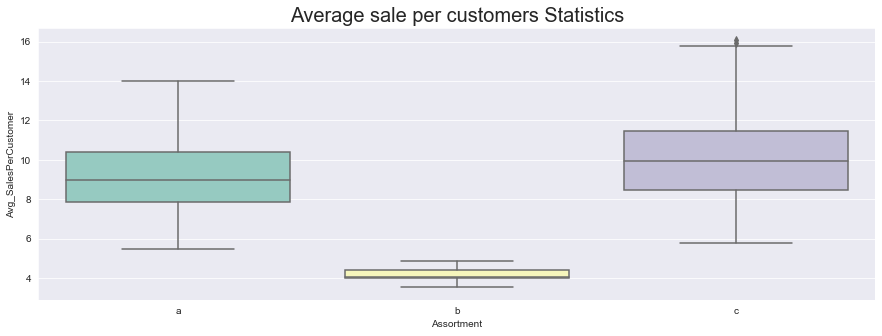

In [34]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='Assortment',data=store,hue_order=['a','b','c'],height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='Assortment',y='Avg_SalesPerCustomer',data=store,order=['a','b','c'],palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* It is quite interesting to observe that the line of assortment type a and c are almost parallel, ie. both are having the same average number of customers but the sales are higher in type c
* Also the sales rate is highest in type c

## 2.6 Visualization based on whether the Promo is continuing 

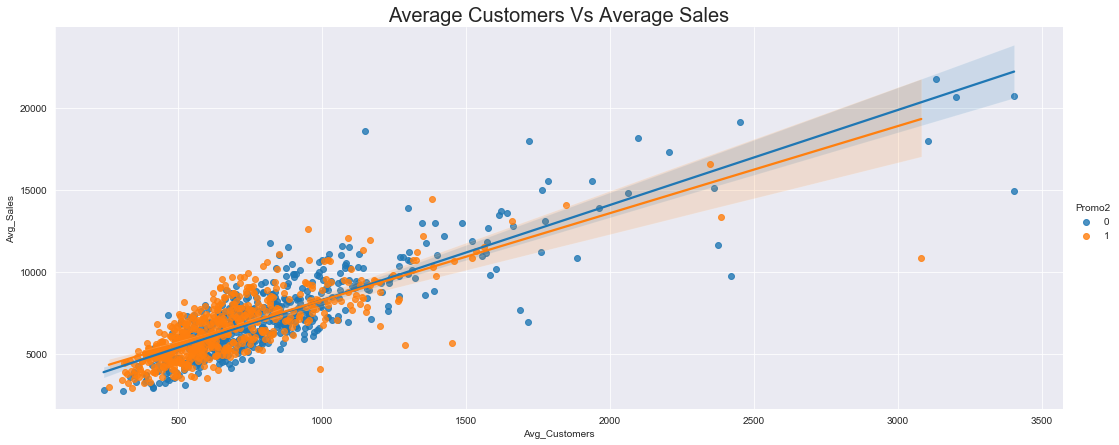

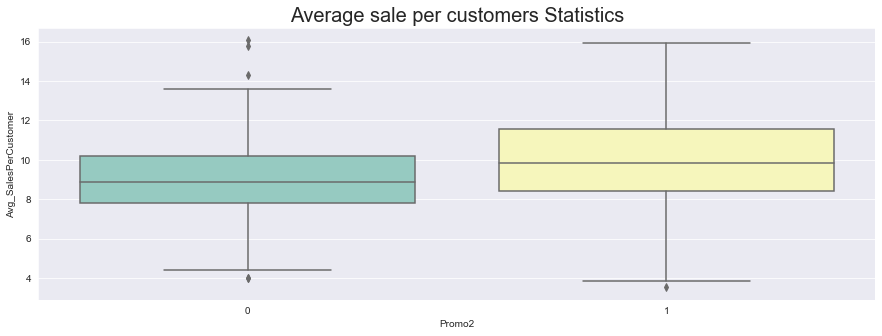

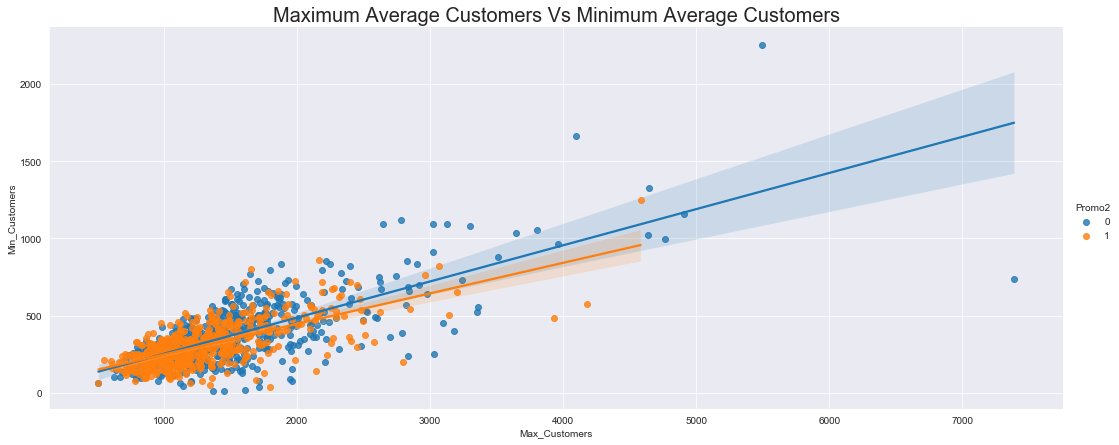

In [35]:
# scatter plot - Average Customers against Average Sales
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='Promo2',data=store,height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='Promo2',y='Avg_SalesPerCustomer',data=store,palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

# scatter plot - Maximum Average Customers against Minimum Average Customers
sns.lmplot(x='Max_Customers',y='Min_Customers',hue='Promo2',data=store,height=6,aspect=2.5)
plt.title('Maximum Average Customers Vs Minimum Average Customers', fontdict={'fontsize':20})
plt.show()

* In the first figure : the line at the begining overlaps each other but as its moves further it diverge from each other with 0 assigned line showing more sales for the same number of customers 
* The box plot shows the sales rate is high for those store who are continuing the promo but the difference is narrow 
* In the last figure : there is still divergence in line and the mimimum number of customers is less for the 1 assigned line as compare to 0 assigned one 
* this indicates the continuing of advertisements and promo is not a good idea as people are getting bored with the same promo.

## 2.7 Visualization based on Promo Interval

<Figure size 1080x576 with 0 Axes>

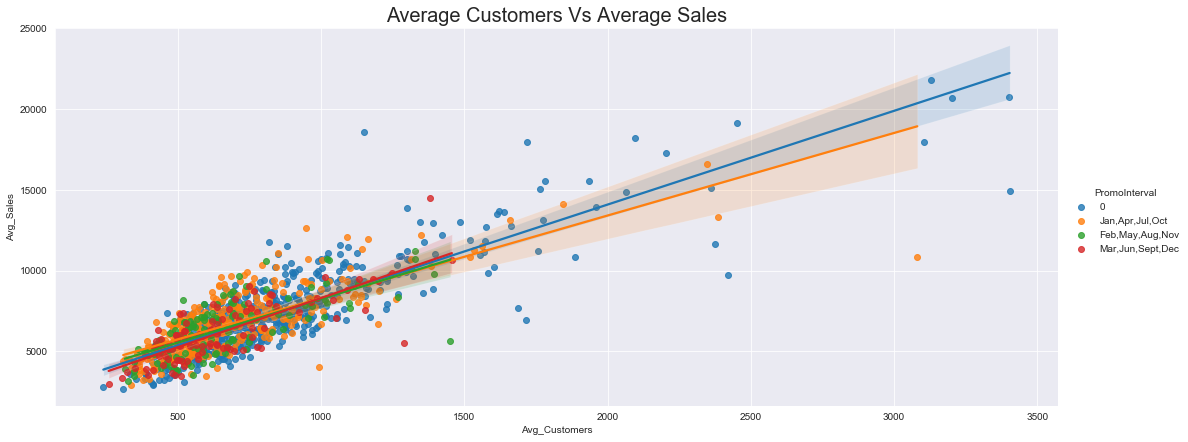

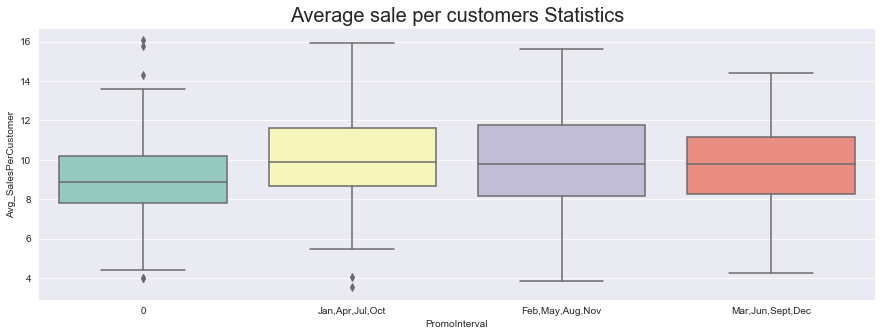

In [36]:
# scatter plot - Average Customers against Average Sales
plt.figure(figsize=(15,8))
sns.lmplot(x='Avg_Customers',y='Avg_Sales',hue='PromoInterval',data=store,height=6,aspect=2.5)
plt.title('Average Customers Vs Average Sales', fontdict={'fontsize':20})
plt.show()

# boxplot - Average sale per customers
plt.figure(figsize=(15,5))
sns.boxplot(x='PromoInterval',y='Avg_SalesPerCustomer',data=store,palette='Set3')
plt.title('Average sale per customers Statistics', fontdict={'fontsize':20})
plt.show()

* The sales rate are almost same 

## 2.8 Table_3 : Average sales, average number of customers and average sales per customer based on StoreType, Assortment and Promo Interval.

In [37]:
Table_3=pd.pivot_table(data=store,index=['StoreType','Assortment','PromoInterval'],
               values=['Avg_Sales','Avg_Customers','Avg_SalesPerCustomer'],aggfunc='mean').round(0)

Table_3.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sales and Average Customers',
              xTitle='(StoreType,Assortment,Assortment)')

Table_3.iplot(y='Avg_SalesPerCustomer',title='Average Sales per customers',xTitle='(StoreType,Assortment,Assortment)')

Table_3

Avg_Customers  Avg_Sales  \
StoreType Assortment PromoInterval                                
a         a          0                       806.000   6720.000   
                     Feb,May,Aug,Nov         722.000   6150.000   
                     Jan,Apr,Jul,Oct         692.000   6382.000   
                     Mar,Jun,Sept,Dec        730.000   6430.000   
          c          0                       915.000   7955.000   
                     Feb,May,Aug,Nov         753.000   7108.000   
                     Jan,Apr,Jul,Oct         841.000   7606.000   
                     Mar,Jun,Sept,Dec        680.000   6116.000   
b         a          0                      1680.000  10600.000   
                     Jan,Apr,Jul,Oct        2385.000  13314.000   
          b          0                      2320.000  10193.000   
                     Feb,May,Aug,Nov        1451.000   5651.000   
                     Jan,Apr,Jul,Oct        2037.000   7448.000   
                     Mar,Jun,Sept,Dec       1288.000   5511.000   
          c          0                      3105.000  17970.000   
c         a          0                       913.000   7252.000   
                     Feb,May,Aug,Nov         603.000   5502.000   
                     Jan,Apr,Jul,Oct         745.000   6234.000   
                     Mar,Jun,Sept,Dec        924.000   7546.000   
          c          0                       937.000   8125.000   
                     Feb,May,Aug,Nov         632.000   5673.000   
                     Jan,Apr,Jul,Oct         632.000   6037.000   
                     Mar,Jun,Sept,Dec        644.000   6010.000   
d         a          0                       651.000   6924.000   
                     Feb,May,Aug,Nov         539.000   6160.000   
                     Jan,Apr,Jul,Oct         543.000   6200.000   
                     Mar,Jun,Sept,Dec        507.000   5675.000   
          c          0                       679.000   7325.000   
                     Feb,May,Aug,Nov         579.000   7173.000   
                     Jan,Apr,Jul,Oct         584.000   7013.000   
                     Mar,Jun,Sept,Dec        522.000   6004.000   

                                       Avg_SalesPerCustomer  
StoreType Assortment PromoInterval                           
a         a          0                                8.000  
                     Feb,May,Aug,Nov                  9.000  
                     Jan,Apr,Jul,Oct                  9.000  
                     Mar,Jun,Sept,Dec                 9.000  
          c          0                                9.000  
                     Feb,May,Aug,Nov                 10.000  
                     Jan,Apr,Jul,Oct                  9.000  
                     Mar,Jun,Sept,Dec                 9.000  
b         a          0                                6.000  
                     Jan,Apr,Jul,Oct                  6.000  
          b          0                                4.000  
                     Feb,May,Aug,Nov                  4.000  
                     Jan,Apr,Jul,Oct                  4.000  
                     Mar,Jun,Sept,Dec                 4.000  
          c          0                                6.000  
c         a          0                                8.000  
                     Feb,May,Aug,Nov                  9.000  
                     Jan,Apr,Jul,Oct                  8.000  
                     Mar,Jun,Sept,Dec                 8.000  
          c          0                                9.000  
                     Feb,May,Aug,Nov                  9.000  
                     Jan,Apr,Jul,Oct                 10.000  
                     Mar,Jun,Sept,Dec                 9.000  
d         a          0                               11.000  
                     Feb,May,Aug,Nov                 11.000  
                     Jan,Apr,Jul,Oct                 11.000  
                     Mar,Jun,Sept,Dec                11.000  
          c          0       

* From the above table as well as figures it is clear that continuing promo is not helping the business, it does not matter on which month the promo was runned .
* The b type store is most effected as sales rate is lowest

## 2.9 Merging train and store dataset to form new train dataset containing all the attributes 

In [38]:
# Merging
new_train=pd.merge(train,store,how='left',on='Store')
print('New training dataset shape :',new_train.shape)
new_train.head()

New training dataset shape : (844338, 25)


,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Avg_Sales,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers
0,1097,2,2013-01-01,5961,1405,0,a,1,4.243,b,...,0,0,0,9744.600,2420.921,4.015,3804,1055,329.306,2460.000
1,85,2,2013-01-01,4220,619,0,a,1,6.817,b,...,0,0,0,7272.454,1015.401,7.120,1992,433,286.779,929.500
2,259,2,2013-01-01,6851,1444,0,a,1,4.744,b,...,0,0,0,11656.145,2374.844,4.884,3648,1033,370.452,2418.000
3,262,2,2013-01-01,17267,2875,0,a,1,6.006,b,...,0,0,0,20718.516,3402.011,6.057,5494,2255,580.749,3239.000
4,274,2,2013-01-01,3102,729,0,a,1,4.255,b,...,10,2013,"Jan,Apr,Jul,Oct",4070.828,992.741,4.035,1962,480,247.459,926.000


In [39]:
# Making new columns to show Date information separately 
new_train['Year']=new_train['Date'].dt.year
new_train['Month']=new_train['Date'].dt.month
new_train['Day']=new_train['Date'].dt.day
new_train['Week']=new_train['Date'].dt.week
new_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,StoreType,...,Avg_Customers,Avg_SalesPerCustomer,Max_Customers,Min_Customers,Std_Customers,Med_Customers,Year,Month,Day,Week
0,1097,2,2013-01-01,5961,1405,0,a,1,4.243,b,...,2420.921,4.015,3804,1055,329.306,2460.000,2013,1,1,1
1,85,2,2013-01-01,4220,619,0,a,1,6.817,b,...,1015.401,7.120,1992,433,286.779,929.500,2013,1,1,1
2,259,2,2013-01-01,6851,1444,0,a,1,4.744,b,...,2374.844,4.884,3648,1033,370.452,2418.000,2013,1,1,1
3,262,2,2013-01-01,17267,2875,0,a,1,6.006,b,...,3402.011,6.057,5494,2255,580.749,3239.000,2013,1,1,1
4,274,2,2013-01-01,3102,729,0,a,1,4.255,b,...,992.741,4.035,1962,480,247.459,926.000,2013,1,1,1


* 4 new columns were added

In [40]:
# Making column "MonthCompetitionOpen" which contains date information in months since the competition was opened 
new_train['MonthCompetitionOpen']=12*(new_train['Year']-new_train['CompetitionOpenSinceYear'])+\
new_train['Month']-new_train['CompetitionOpenSinceMonth']

new_train.loc[(new_train['CompetitionOpenSinceYear']==0),'MonthCompetitionOpen']=0
# Negative values indcate that the competitor's store was opened after the Rossman's store opening date.

In [41]:
# Making column "WeekPromoOpen" which contains date information in weeks since the promo is running
new_train['WeekPromoOpen']=52.14298*(new_train['Year']-new_train['Promo2SinceYear'])+\
new_train['Week']-new_train['Promo2SinceWeek']

new_train.loc[(new_train['Promo2SinceYear']==0),'WeekPromoOpen']=0

## 2.10 Visualization based on Months 

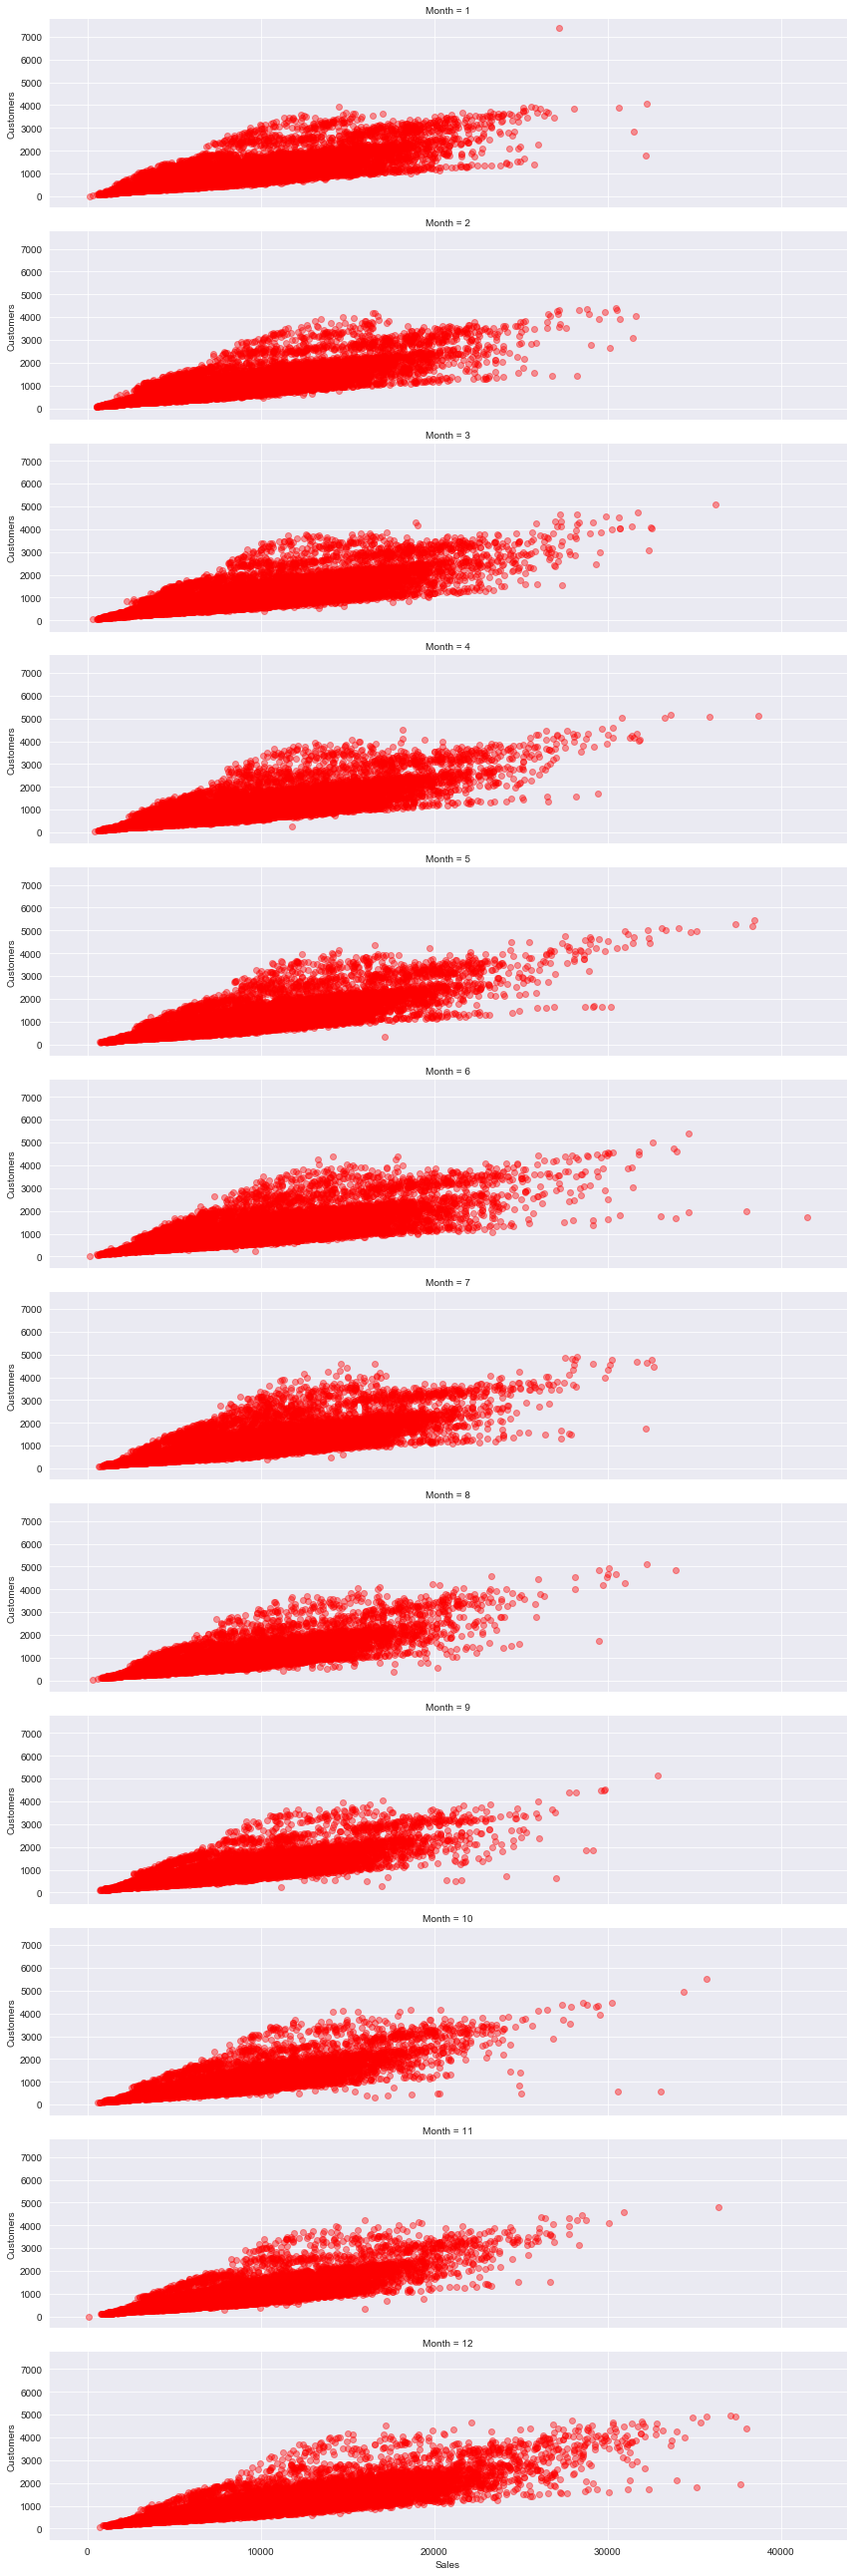

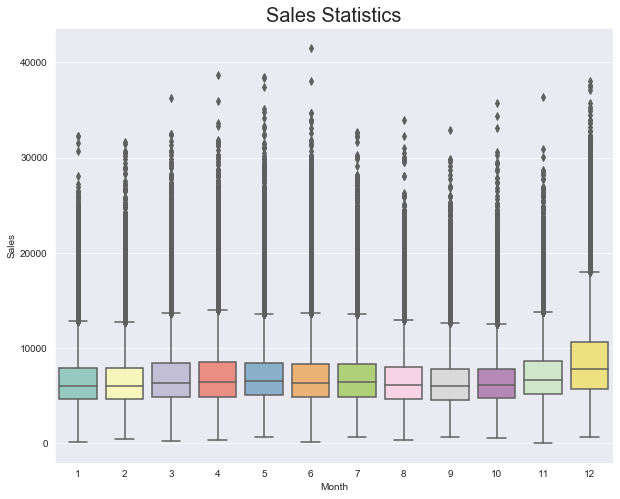

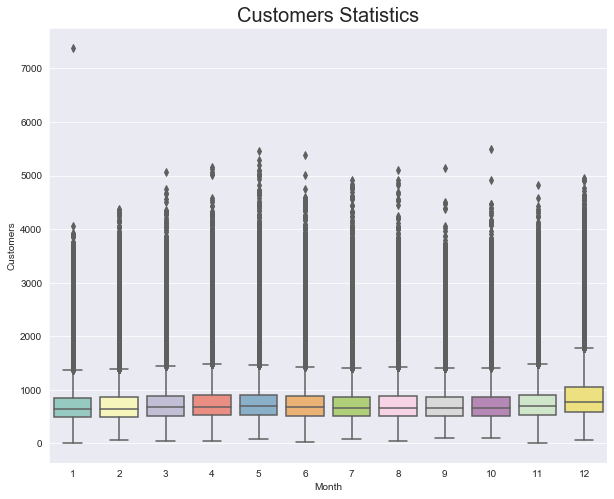

In [42]:
# scatter plot - Sales against Customers
g=sns.FacetGrid(row='Month',data=new_train,height=3,aspect=4)
g.map(plt.scatter,'Sales','Customers',color='red',alpha=0.4)
plt.show()

# Boxplot - "Sales"
plt.figure(figsize=(10,8))
sns.boxplot(y='Sales',x='Month',data=new_train,palette='Set3')
plt.title('Sales Statistics',fontdict={'fontsize':20})
plt.show()

# Boxplot - "Customers"
plt.figure(figsize=(10,8))
sns.boxplot(y='Customers',x='Month',data=new_train,palette='Set3')
plt.title('Customers Statistics',fontdict={'fontsize':20})
plt.show()

* Now it is obvious that the month of November and December the sale and number of customers would be high
* Sales are also high in the summer season

## 2.11 Table_4 : Average sales, average number of customers and average sales per customer based on Months.

In [43]:
Table_4=pd.pivot_table(data=new_train,index=['Month','Promo'],
                      values=['Avg_Sales','Avg_Customers','Avg_SalesPerCustomer'],aggfunc='mean').round(0)

# Visualization
Table_4.iplot(kind='bar',y=['Avg_Sales','Avg_Customers'],title='Average Sale and Average Customers',xTitle='(Months,Promo)')
Table_4.iplot(y='Avg_SalesPerCustomer',title='Average sales per customer',xTitle='(Months,Promo)')

del(Table_4)

In [44]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   SalesPerCustomer           844338 non-null  float64       
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64 

In [45]:
# converting into integer type
new_train['Promo2']=new_train['Promo2'].astype(int)

In [46]:
"""Droping column customer because we are performing sales prediction and knowing the number of customers on particular store before actual
   sales happen is not possible"""
new_train.drop('Customers',axis=1,inplace=True)

# 3. Building and Implementing Machine Learning Models

## 3.1 Preparing dataset and Normalizing certain column data

In [47]:
# Making a new data set for model building
trainS=new_train[['Store', 'DayOfWeek','Sales','Promo',
       'StateHoliday', 'SchoolHoliday','StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval','Avg_Customers',
       'Max_Customers', 'Min_Customers',
       'Std_Customers', 'Med_Customers', 'Year', 'Month', 'Day', 'Week',
       'MonthCompetitionOpen', 'WeekPromoOpen']]
trainS.shape

(844338, 26)

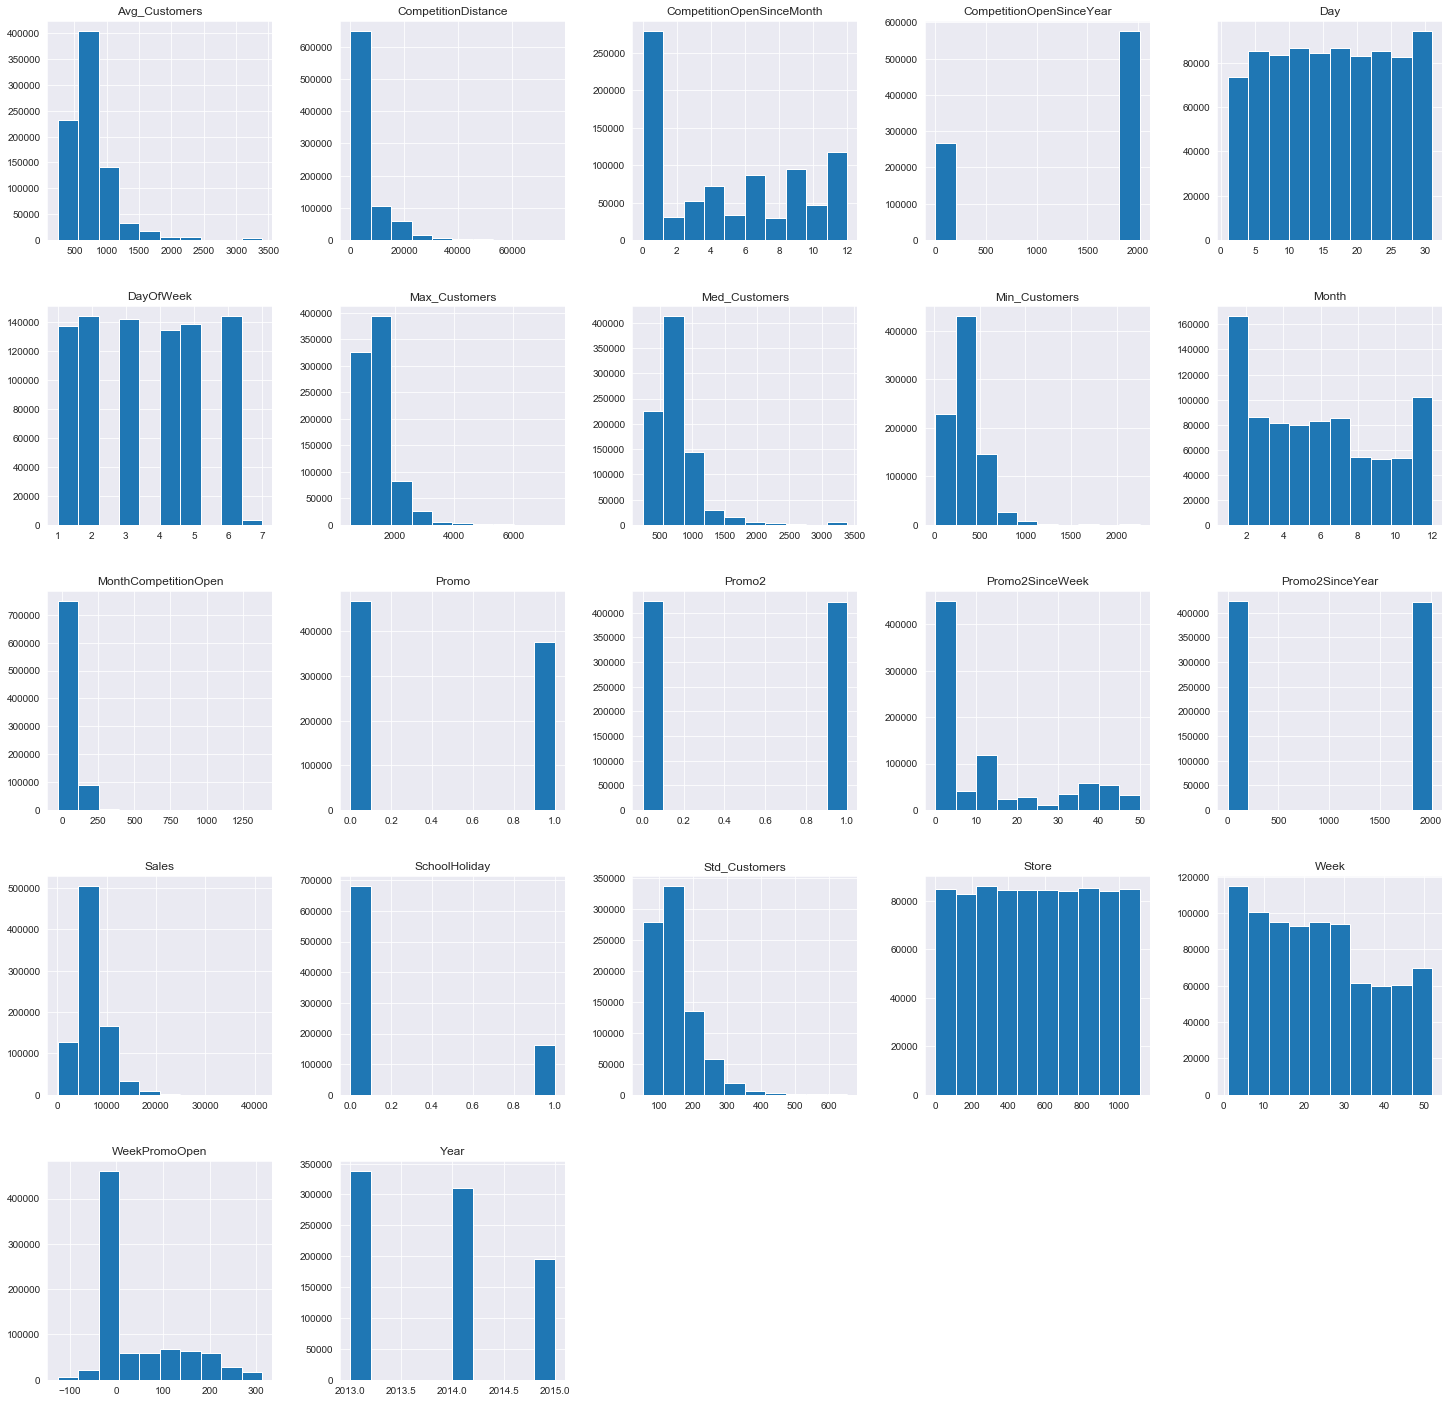

In [48]:
# Visualization to chech whether the data is distributed normally
trainS.hist(figsize=(25,25))
plt.show()

* Some of the columns data are positively skewed, therefore have to deal with it.
* This is not a necessary step but normally distributed data yields better result

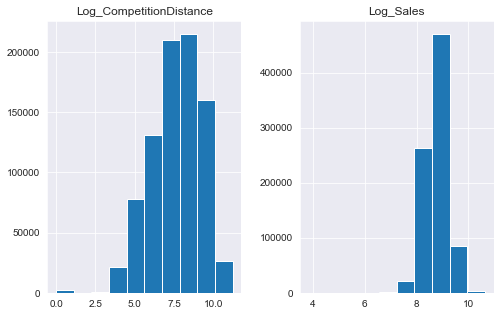

In [49]:
# Taking log transformation 
trainS['Log_Sales']=np.log(trainS['Sales'])

index=trainS[trainS['CompetitionDistance']==0].index
trainS['CompetitionDistance'][index]=1
trainS['Log_CompetitionDistance']=np.log(trainS['CompetitionDistance'])

trainS[['Log_Sales','Log_CompetitionDistance',]].hist(figsize=(8,5))
plt.show()

trainS.drop(['Sales','CompetitionDistance'],axis=1,inplace=True)

# Note : This is not a necessary step but doing this will redistribute the data in normal curve which is better for good prediction 

* Almost normally distributed 

In [50]:
# Getting dummies columns for categorical columns 
final_train=pd.get_dummies(data=trainS,columns=['StoreType','StateHoliday','Assortment','PromoInterval'])
final_train.shape

(844338, 37)

## 3.2 Model Building : Random Forest Regressor 

### 3.2.1 Spliting the dataset

In [51]:
# Spliting dataset into X and y 
X=final_train.drop('Log_Sales',axis=1)
y=final_train['Log_Sales']

# Spliting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101) 

### 3.2.2 Creating and Training the model 

In [52]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor(n_estimators=200,
                          criterion='mse',
                          max_features='sqrt',
                          oob_score=True,
                          n_jobs=8,
                          verbose=1,
                          random_state=101)

rfr.fit(X_train,y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  6.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=8, oob_score=True,
                      random_state=101, verbose=1, warm_start=False)

In [53]:
# Prediction
predict=rfr.predict(X_test)
predict

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 87.4min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed: 94.9min finished


array([8.63712655, 9.4132319 , 9.13232578, ..., 8.51220279, 8.58855105,
       8.96356625])

### 3.2.3 Model Evaluation 

In [54]:
# Out of Bag score
print('oob score :',rfr.oob_score_)

oob score : 0.9228561536464273


In [55]:
# Root mean square error
from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(np.exp(y_test),np.exp(predict))
print('Root Mean Square Error {}'.format(sqrt(mse)))

Root Mean Square Error 854.7540464572055


In [56]:
# Import attributes according to model
pd.options.display.float_format='{:.5f}'.format
important_features=pd.DataFrame(rfr.feature_importances_,index=X_train.columns)
important_features.sort_values(by=0,ascending=False)

,0
Avg_Customers,0.14396
Promo,0.14349
Med_Customers,0.11767
Max_Customers,0.10567
DayOfWeek,0.08525
Min_Customers,0.07278
Std_Customers,0.05137
Day,0.04265
Week,0.03444
Log_CompetitionDistance,0.02397


In [57]:
# Visualization of important features
important_features.sort_values(by=0,ascending=False).iplot(mode='markers',title='Important Attributes')

### 3.2.4 Predictions from Model

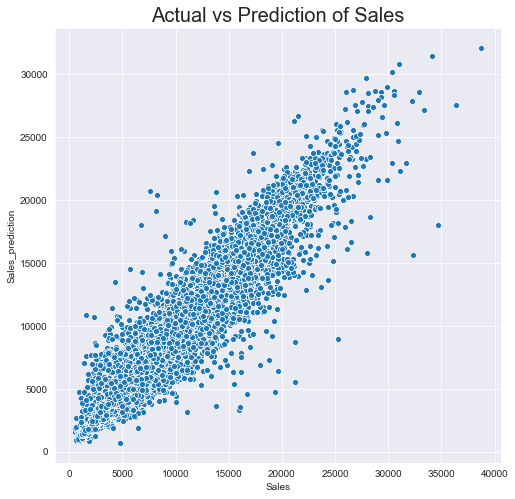

,Sales,Sales_prediction
0,4880.00000,5637.00000
1,11791.00000,12249.00000
2,10209.00000,9250.00000
3,4915.00000,4966.00000
4,6457.00000,7620.00000
...,...,...
126646,7222.00000,6703.00000
126647,10666.00000,8400.00000
126648,5990.00000,4975.00000
126649,6884.00000,5370.00000


In [58]:
prediction=pd.DataFrame(np.exp(y_test))
prediction['Sales_prediction']=np.exp(predict).round()
prediction.rename(columns={'Log_Sales':'Sales'},inplace=True)

# Visualization
plt.figure(figsize=(8,8))
sns.scatterplot(x='Sales',y='Sales_prediction',data=prediction)
plt.title('Actual vs Prediction of Sales',fontdict={'fontsize':20})
plt.show()

prediction.reset_index(inplace=True)
prediction.drop('index',axis=1,inplace=True)
prediction

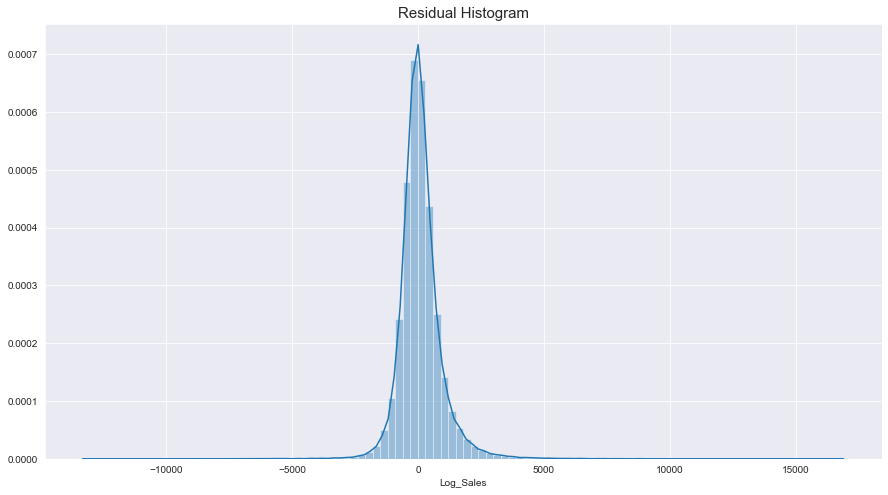

In [59]:
# Residual Histogram
plt.figure(figsize=(15,8))
sns.distplot((np.exp(y_test)-np.exp(predict)),bins=100)
plt.title('Residual Histogram',fontdict={'fontsize':15})
plt.show()

#### Further model can be enhanced by
* Droping some of the very low assigned weightage columns 
* Standard normalize scaling the whole dataset
* Hyper tuning the parameters 

#### Some of the code for hyper tuning the parameters using GridSearchCv

      from sklearn.model_selection import GridSearchCV
      from sklearn.ensemble import RandomForestRegressor

      rfr=RandomForestRegressor(random_state=101)

      param_grid=dict(n_estimators=np.arange(200,500,50),max_depth=np.arange(2,6,1),
                max_features=['auto','sqrt'],min_samples_leaf=[3,4,5],min_samples_split=[3,4,5])

      gridSearch=GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 4, n_jobs = 32,
                        verbose=1,scoring='neg_mean_squared_error')

      gridSearch.fit(X_train,y_train)
      gridSearch.best_param

* Using best parameter obtain by GridSearch to build again random forest model and making the prediction and evaluating the model based on root mean square error.

Note : I have not performed hypertuning because i have used maximum of my system ram.

Thank you ~ PRASHANT LAL